# Credit Card Fraud Detection

If you would like to run this notebook yourself manually, download the dataset from [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- Extract and **copy paste** the "creditcard.csv" file into your Downloads

You may create your own Conda environment using this [environment.yml file](https://github.com/aryanjajoo/fraud-detection/blob/main/environment.yml)

#### Objective

There are:
- 284807 total transactions
- 492 fraudulent transactions

My objective is to build a good model for fraud detection, since it's a very common problem for many businesses and costs them on average 5% of their annual revenue. I want to try different machine learning models and use oversampling techniques such as SMOTE to deal with the high imbalance in the dataset since fraudulent transactions are so rare.

#### Contents

1. EDA (Exploratory Data Analysis)
2. Logistic Regression
3. Logistic Regression (with SMOTE)
4. Random Forest Classifier
5. Random Forest Classifier (with SMOTE)
6. Hyperparameter Tuning for the best model

#### What is SMOTE?

Since our dataset is very imbalanced and there's a very small number of fraudulent transactions, we can use SMOTE to create new synthetic samples of the minority class (it looks at the real examples and creates slightly different ones based on them) so the models learn better and doesn't ignore the minority group (which are the fraudulent transactions).

# EDA (Exploratory Data Analysis)

In [1]:
import pandas as pd

df = pd.read_csv("creditcard.csv")

In [2]:
# First 5 rows of the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The features in this dataset are:
- Time
- V1 - V28
- Amount (transcation amount)
- Class (0 for legitimate transactions and 1 for fraudulent ones)

For context: V1-V28 are anonimized features obtained from principal component analysis, we do not know what each component represents, however the model can learn patterns from the different values from V1-V28 and use that to determine if a transaction is fraudulent or not.

In [3]:
# Total amounts of both types of transactions
totals = df['Class'].value_counts()

print("0: Not fraud\n1: Fraud\n")
print(totals)

0: Not fraud
1: Fraud

Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
print("Ratio of fraudulent cases to non fraudulent cases\n")
print(totals / len(df.index))

Ratio of fraudulent cases to non fraudulent cases

Class
0    0.998273
1    0.001727
Name: count, dtype: float64


## PCA plot

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df.drop("Class", axis=1)
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to reduce dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

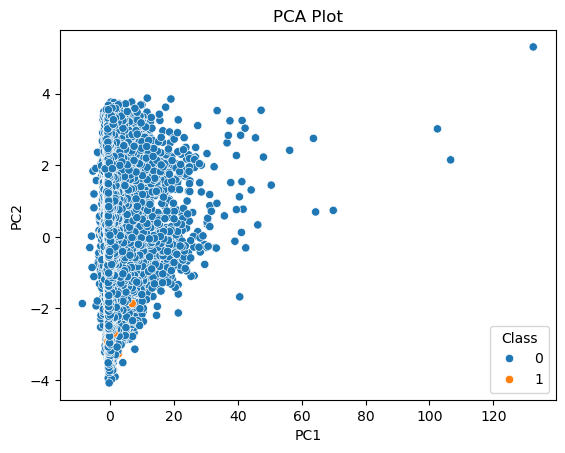

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# New dataframe with PCA components
# PC1 and PC2 are the principal components
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Class'] = y

# Scatterplot of the 2 principal components
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue="Class")
plt.title('PCA Plot')
plt.show()

In this scatterplot:
- 0 represents non fraudulent cases
- 1 represents fraudulent cases

## Splitting the dataset

In [8]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and test sets
# 70% will be used for training
# 30% will be used for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Logistic Regression (without SMOTE)

I used a scaler to standardize my features since logistic regression is sensitive to scaling and it helps a lot since logistic regression benefits from scaling.

I decided to also use a pipeline which essentially helps combine multiple steps into one in a clean and efficient manner. It also helps prevent data leakage since pipelines are automatic and safer on average.

In [9]:
from imblearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression

# Scaler
scaler = StandardScaler()

# The model
logreg_model = LogisticRegression(max_iter=2000, solver='saga', random_state=42)

# Defining the pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('Logistic Regression', logreg_model),
])

pipeline.fit(X_train, y_train)

# Storing the predictions
y_pred = pipeline.predict(X_test)

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculating metrics and rounding them to 2 decimal places
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)

# Adding results to a list for later comparisons
results_logreg = [['Logistic Regression (no SMOTE)', precision, recall, f1]]

# This will be the dataframe that contains all the results from all the models
final_results = pd.DataFrame(results_logreg, columns=['Model', 'Precision', 'Recall', 'F1-Score'])

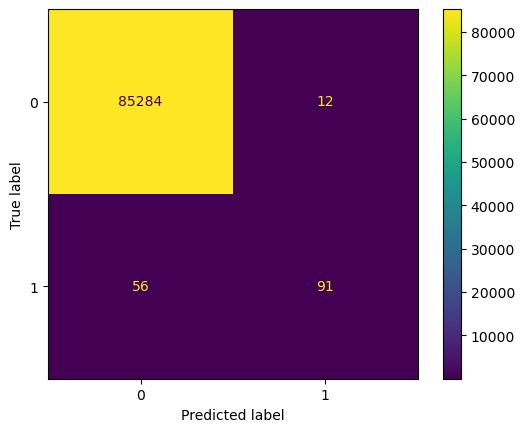

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [12]:
from sklearn.metrics import classification_report

# The classification report
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.88      0.62      0.73       147

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [13]:
final_results

,Model,Precision,Recall,F1-Score
0,Logistic Regression (no SMOTE),0.88,0.62,0.73


### Results of Logistic Regression (without SMOTE)

- Precision of 0.88 means when the model predicted a transaction as fraud, it was correct 88% of the time.
- Recall of 0.62 indicates that the model detected 62% of all fraud cases, so 38% of fraud cases were missed.

I didn't use accuracy as a metric since this is a very imbalanced dataset, which means that almost all the transactions are not fraudulent. This means the model can simply achieve a very high accuracy by guessing every single case as non fraudulent, which is meaningless for a fraud detection model.

So far, for the first model the precision is very good (so 88% of the time, when the model said a transaction was fraudulent, it was correct), however the recall can be improved. Since it still misses 38% of fraud cases, and missing that many can be costly for any business.

# Logistic Regression (with SMOTE)

Here I will be using Logistic Regression combined with SMOTE using a pipeline. It will be the same thing as the previous model, however this time I am using SMOTE to oversample my data. Since SMOTE increases my dataset by a lot.

**What is SMOTE?**

Since our dataset is very imbalanced and there's a very small number of fraudulent transactions, we can use SMOTE to create new synthetic samples of the minority class (it looks at the real examples and creates slightly different ones based on them) so the models learn better and doesn't ignore the minority group (which are the fraudulent transactions).

In [15]:
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()

# Using SMOTE for oversampling
resampling = SMOTE(random_state=42)

# Max iterations increased to help the model converge
logreg_smote = LogisticRegression(max_iter=5000, solver='saga', random_state=42)

# The pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('SMOTE', resampling),
    ('Logistic Regression', logreg_smote),
])

pipeline.fit(X_train, y_train)

# Storing predictions
y_pred = pipeline.predict(X_test)

In [16]:
# Calculating metrics and rounding them to 2 decimal places
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)

# Storing the results
results_logreg_smote = [['Logistic Regression (with SMOTE)', precision, recall, f1]]
df_logreg_smote = pd.DataFrame(results_logreg_smote, columns=['Model', 'Precision', 'Recall', 'F1-Score'])

# Adding the results to the final results dataframe
final_results = pd.concat([final_results, df_logreg_smote], ignore_index=True)

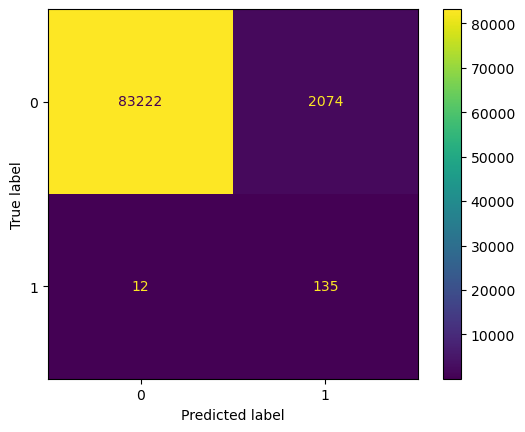

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [18]:
# The classification report
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85296
           1       0.06      0.92      0.11       147

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443



In [19]:
final_results

,Model,Precision,Recall,F1-Score
0,Logistic Regression (no SMOTE),0.88,0.62,0.73
1,Logistic Regression (with SMOTE),0.06,0.92,0.11


### Results of Logistic Regression (with SMOTE)

It seems smote made it worse for Logistic regression. My recall did get better with smote, meaning more fraudulent transactions are caught by the model, however the precision shot down, meaning its flagging so many legit transactions as fraudulent, this is terrible in real life for a company as this would cause far more problems than just simply catching a few extra fraud cases, since many real customers would be annoyed and frustrated if their transaction is falsely flagged as fraudulent.

While SMOTE is often helpful, I think it confused the linear regression model since it couldn't really capture the complex underlying patterns and therefore the precision shot down as it started flagging most transactions as fraudulent and couldn't distinguish between what is legitimate and fraudulent easily.

# Random Forest Classifier (without SMOTE)

Random Forest is non-linear model that is very good for capturing complex patterns. It can likely handle the complexity (especially that comes with SMOTE) better than logistic regression.

In [20]:
from sklearn.ensemble import RandomForestClassifier

# The random forest classifier
rf_model = RandomForestClassifier(n_estimators=20, random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [21]:
# Calculating metrics and rounding them to 2 decimal places
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)

# Storing results
results_rf = [['Random Forest Classifier (no SMOTE)', precision, recall, f1]]
df_rf = pd.DataFrame(results_rf, columns=['Model', 'Precision', 'Recall', 'F1-Score'])

# Adding the results to the final results dataframe
final_results = pd.concat([final_results, df_rf], ignore_index=True)

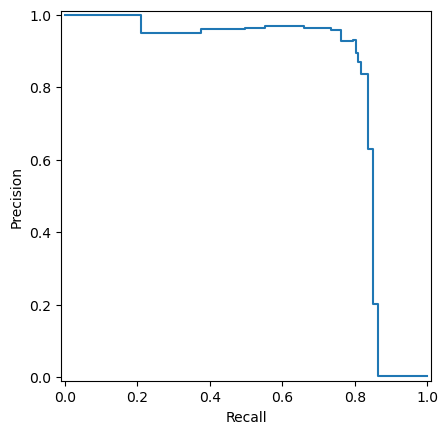

In [22]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

probs = rf_model.predict_proba(X_test)[:, 1]

# This graph shows how the precision and recall relationship changes
precision, recall, _ = precision_recall_curve(y_test, probs)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score

# This is the ROC AUC score (area under the curve) and it is a value between 0 and 1
# The higher the score, the better the model.
roc_auc_rf = roc_auc_score(y_test, probs)
print(roc_auc_rf)

0.9314910732629198


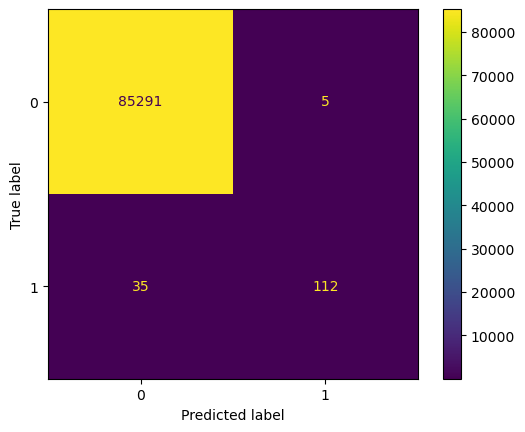

In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [25]:
# Classification report
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.96      0.76      0.85       147

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [26]:
final_results

,Model,Precision,Recall,F1-Score
0,Logistic Regression (no SMOTE),0.88,0.62,0.73
1,Logistic Regression (with SMOTE),0.06,0.92,0.11
2,Random Forest Classifier (no SMOTE),0.96,0.76,0.85


### Results of Random Forest Classifier (without SMOTE)

It already seems that my Random Forest classifier (even without SMOTE) handles fraud detection far better than logistic regression. Since out of the first 2 models, logistic regression without SMOTE was the better one overall, and this model is simply a big improvement in both precision and recall. I'm pretty happy with that.

# Random Forest Classifier (with SMOTE)

I will do the same things as before, however test with SMOTE for my random forest classifier

In [27]:
resampling = SMOTE(random_state=42)
rf_smote = RandomForestClassifier(n_estimators=20, random_state=42)

# The pipeline
pipeline = Pipeline([
    ('SMOTE', resampling),
    ('rf', rf_smote)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [28]:
# Calculating metrics and rounding them to 2 decimal places
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)

# Storing results
results_rf_smote = [['Random Forest Classifier (with SMOTE)', precision, recall, f1]]
df_rf_smote = pd.DataFrame(results_rf_smote, columns=['Model', 'Precision', 'Recall', 'F1-Score'])

# Adding the results to the final results dataframe
final_results = pd.concat([final_results, df_rf_smote], ignore_index=True)

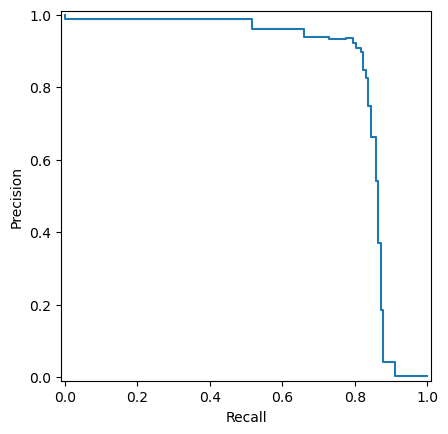

In [29]:
probs = pipeline.predict_proba(X_test)[:, 1]

# This graph shows how the precision and recall relationship changes
precision, recall, _ = precision_recall_curve(y_test, probs)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [30]:
roc_auc_rf_smote = roc_auc_score(y_test, probs)
print(roc_auc_rf_smote)

0.9534410462740716


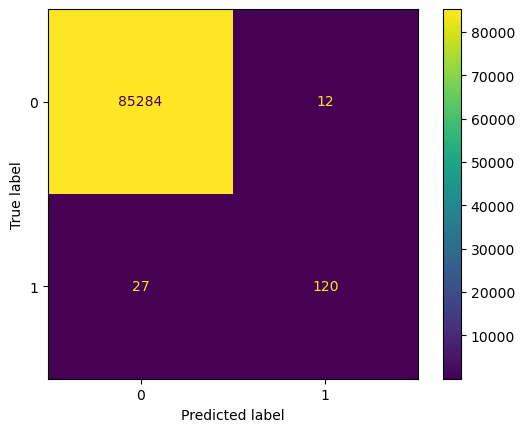

In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [32]:
# Classification report
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.91      0.82      0.86       147

    accuracy                           1.00     85443
   macro avg       0.95      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [33]:
final_results

,Model,Precision,Recall,F1-Score
0,Logistic Regression (no SMOTE),0.88,0.62,0.73
1,Logistic Regression (with SMOTE),0.06,0.92,0.11
2,Random Forest Classifier (no SMOTE),0.96,0.76,0.85
3,Random Forest Classifier (with SMOTE),0.91,0.82,0.86


### Results of Random Forest Classifier (with SMOTE)

SMOTE improved my recall quite a bit for my random forest classifier, even if the precision went down a bit, getting the recall up was worth it since missing fewer fraudulent transactions is valuable in real life for businesses (but of course you should also have a good precision score with a good recall) and in my case, my precision is also very good so adding SMOTE was a good improvement.

In [34]:
print("ROC AUC scores:")
print(f"Random Forest Classifier (no SMOTE): {roc_auc_rf}")
print(f"Random Forest Classifier (with SMOTE): {roc_auc_rf_smote}")

ROC AUC scores:
Random Forest Classifier (no SMOTE): 0.9314910732629198
Random Forest Classifier (with SMOTE): 0.9534410462740716


There was also an improvement in my ROC AUC score with SMOTE, and the value was higher and closer to 1, so it was better and also implies SMOTE helped my model.

# Hyperparameter Tuning for Random Forest Classifier

Here I performed a search for the best hyperparameter combination out of the ones I selected below

In [35]:
from sklearn.model_selection import GridSearchCV

# Model
rf = RandomForestClassifier(n_estimators=20, random_state=42)

# Pipeline
pipeline = Pipeline([
    ('smote', resampling),
    ('rf', rf)
])

# These are the parameters I will test, the reason I put rf__ is because I'm using a pipeline
param_grid = {
    'rf__min_samples_split': [5, 6, 7, 8],
    'rf__max_depth': [None, 10],
    'rf__min_samples_leaf': [1, 2]
}

rf_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,

    # Since only focusing on recall gave me bad precision scores, I wanted a good balance of both
    scoring='f1',
    cv=3,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

# Displays the best combination of hyperparameters found from the search
rf_search.best_params_


{'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 6}

Now I will put in the best parameter combination according to the search above in the final Random Forest Classifier below. 

Also a small note, I already tried using higher n_estimators like 50, 100 or even 200, but 20 yields the best results so I will keep the final model at 20

In [36]:
resampling = SMOTE(random_state=42)

# Best model
rf_final = RandomForestClassifier(n_estimators=20, min_samples_split=6, min_samples_leaf=1, max_depth=None, n_jobs=-1, random_state=42)

# Pipeline
pipeline_rf_final = Pipeline([
    ('SMOTE', resampling),
    ('rf', rf_final)
])

pipeline_rf_final.fit(X_train, y_train)
y_pred = pipeline_rf_final.predict(X_test)

In [37]:
# Calculating metrics and rounding them to 2 decimal places
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)

# Storing results
results_rf_final = [['Random Forest Classifier (final)', precision, recall, f1]]
df_rf_final = pd.DataFrame(results_rf_final, columns=['Model', 'Precision', 'Recall', 'F1-Score'])

# Adding the results to the final results dataframe
final_results = pd.concat([final_results, df_rf_final], ignore_index=True)

In [38]:
# Classification report
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.91      0.83      0.87       147

    accuracy                           1.00     85443
   macro avg       0.96      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [39]:
final_results

,Model,Precision,Recall,F1-Score
0,Logistic Regression (no SMOTE),0.88,0.62,0.73
1,Logistic Regression (with SMOTE),0.06,0.92,0.11
2,Random Forest Classifier (no SMOTE),0.96,0.76,0.85
3,Random Forest Classifier (with SMOTE),0.91,0.82,0.86
4,Random Forest Classifier (final),0.91,0.83,0.87


### Hyperparameter tuning results

I believe the model was already performing near its best, so even though I tried quite a few combinations for hyperparameters tuning, there wasn't a massive improvement. However my precision did go up from 0.82 to 0.83 and f1-score from 0.86 to 0.87, which I'm glad about since every little improvement still counts and helps.

Overall I am very happy with my final model's performance. In the end my model got:
- Precision of 0.91
- (Out of all the transactions, when my model predicted a transaction as fraudulent, it was correct 91% of the time)

- Recall of 0.83
- (The model caught 83% of all the real fraudulent transactions)

### Saving with joblib for future use

In [40]:
import joblib

# Saving the best model using joblib
joblib.dump(pipeline_rf_final, 'fraud_detection_pipeline.pkl')

['fraud_detection_pipeline.pkl']